In [2]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt

from transformers import pipeline, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, hamming_loss, precision_recall_curve


In [11]:
import pandas as pd
df = pd.read_csv('/content/data2/FoodData.csv')
df.head()

,Class,Type,Group,Food,Allergy
0,Plant origin,Nut and seed,Oil seed,Almond,Nut Allergy
1,Plant origin,Fruit,Pome fruit,Apple,Oral Allergy Syndrome
2,Plant origin,Fruit,Stone fruit,Apricot,Stone Fruit Allergy
3,Plant origin,Vegetable,Composite vegetable,Artichoke,Insulin Allergy
4,Plant origin,Vegetable,Liliaceous vegetable,Asparagus,Allium Allergy


In [10]:
from google.colab import files
files.upload()

Saving allergens.json to allergens.json


{'allergens.json': b'{"en:peach":{"name":{"ja":"\xe3\x82\x82\xe3\x82\x82","en":"Peach"}},"en:milk":{"name":{"en":"Milk","ga":"Bainne","nb":"Melk","sl":"Mleko","fi":"Maito","hu":"Tej","ja":"\xe4\xb9\xb3","zh":"\xe4\xb9\xb3","et":"Laktoos","ru":"\xd0\x9c\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xba\xd0\xbe","ro":"Lapte","he":"\xd7\x97\xd7\x9c\xd7\x91","is":"Mj\xc3\xb3lk","sr":"Mleko","fr":"Lait","cs":"Ml\xc3\xa9ko","el":"\xce\x93\xce\xac\xce\xbb\xce\xb1","lt":"I\xc5\xa1r\xc5\xabg\xc5\xb3","sv":"Mj\xc3\xb6lk","pt":"Leite","sk":"Mlieko","de":"Milch","nl":"Melk","it":"Latte","lv":"Laktozi","da":"M\xc3\xa6lk","bg":"\xd0\xa1\xd1\x83\xd1\x80\xd0\xbe\xd0\xb2\xd0\xb0\xd1\x82\xd0\xba\xd0\xb0","th":"\xe0\xb8\x99\xe0\xb8\xa1","es":"Leche","mt":"\xc4\xa6alib","ar":"\xd8\xad\xd9\x84\xd9\x8a\xd8\xa8\xd8\xa8","pl":"Mleko","hr":"Laktoza"}},"en:gluten":{"name":{"th":"\xe0\xb8\x81\xe0\xb8\xa5\xe0\xb8\xb9\xe0\xb9\x80\xe0\xb8\x95\xe0\xb9\x87\xe0\xb8\x99","bg":"\xd0\x93\xd0\xbb\xd1\x83\xd1\x82\xd0\xb5\xd0\xbd","da":"Glut

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for security


In [6]:
!mkdir -p /content/data
!kaggle datasets download -d openfoodfacts/world-food-facts -p /content/data --unzip



Dataset URL: https://www.kaggle.com/datasets/openfoodfacts/world-food-facts
License(s): DbCL-1.0
100% 109M/109M [00:05<00:00, 33.3MB/s]
100% 109M/109M [00:05<00:00, 21.7MB/s]


In [7]:
!mkdir -p /content/data2
!kaggle datasets download boltcutters/food-allergens-and-allergies -p /content/data2 --unzip



Dataset URL: https://www.kaggle.com/datasets/boltcutters/food-allergens-and-allergies
License(s): copyright-authors
  0% 0.00/2.17k [00:00<?, ?B/s]
100% 2.17k/2.17k [00:00<00:00, 4.95MB/s]


In [12]:
# Build a dictionary mapping each food (lowercased and stripped) to its allergy label(s)
food_allergy_dict = {}
for idx, row in df.iterrows():
    food_key = str(row["Food"]).lower().strip()
    allergy_label = row["Allergy"]
    if food_key not in food_allergy_dict:
        food_allergy_dict[food_key] = set()
    food_allergy_dict[food_key].add(allergy_label)

print("\nFood-Allergy dictionary sample:")
for food, allergies in list(food_allergy_dict.items())[:5]:
    print(f"{food}: {allergies}")


Food-Allergy dictionary sample:
almond: {'Nut Allergy'}
apple: {'Oral Allergy Syndrome'}
apricot: {'Stone Fruit Allergy'}
artichoke: {'Insulin Allergy'}
asparagus: {'Allium Allergy'}


In [13]:
model_name = "sgarbi/bert-fda-nutrition-ner"
ner_pipe = pipeline("token-classification", model=model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
def get_allergies_from_ingredients(ingredients_text: str):
    """
    Run the NER model on the input text, clean tokens, and check against our food-allergy dictionary.
    Returns a list of detected allergy labels.
    """
    ner_results = ner_pipe(ingredients_text)
    detected_allergies = set()

    for token_info in ner_results:
        token = token_info["word"]
        token_clean = re.sub(r'\W+', '', token.lower().strip())
        if token_clean in food_allergy_dict:
            allergies_for_token = food_allergy_dict[token_clean]
            detected_allergies.update(allergies_for_token)

    return list(detected_allergies)

In [15]:
test_data = [
    ("Dried apricots, walnuts, honey, lemon juice", ["Citrus Allergy", "Honey Allergy", "Nut Allergy"]),
    ("Apples and almond butter on toast", ["Oral Allergy Syndrome", "Nut Allergy"]),
    ("Almond cookies with wheat flour", ["Nut Allergy"])
]

y_true = []  # Gold standard allergy labels
y_pred = []  # Predicted allergy labels

print("\n=== PREDICTION EXAMPLES ===")
for text, gold_allergies in test_data:
    predicted_allergies = get_allergies_from_ingredients(text)
    print(f"Text: {text}")
    print(f"Gold Allergies: {gold_allergies}")
    print(f"Detected Allergies: {predicted_allergies}\n")
    y_true.append(gold_allergies)
    y_pred.append(predicted_allergies)



=== PREDICTION EXAMPLES ===
Text: Dried apricots, walnuts, honey, lemon juice
Gold Allergies: ['Citrus Allergy', 'Honey Allergy', 'Nut Allergy']
Detected Allergies: ['Citrus Allergy', 'Nut Allergy', 'Honey Allergy']

Text: Apples and almond butter on toast
Gold Allergies: ['Oral Allergy Syndrome', 'Nut Allergy']
Detected Allergies: ['Milk allergy / Lactose intolerance', 'Nut Allergy']

Text: Almond cookies with wheat flour
Gold Allergies: ['Nut Allergy']
Detected Allergies: ['Gluten Allergy', 'Nut Allergy']



Device set to use cuda:0


Enter the ingredient list: "peanuts", "gluten", "milk", "soy", "egg", "tree nut", "wheat", "fish", "shellfish"

Detected Allergens: ['wheat', '##fish', 'milk', 'fish', 'soy', 'peanuts', 'egg']

Alternative Product Suggestions:
                     product_name  nutrition-score-fr_100g  \
0              Farine de blé noir                      NaN   
1  Banana Chips Sweetened (Whole)                     14.0   
3          Organic Salted Nut Mix                     12.0   

                                    ingredients_text  
0                                                NaN  
1  Bananas, vegetable oil (coconut oil, corn oil ...  
3  Organic hazelnuts, organic cashews, organic wa...  


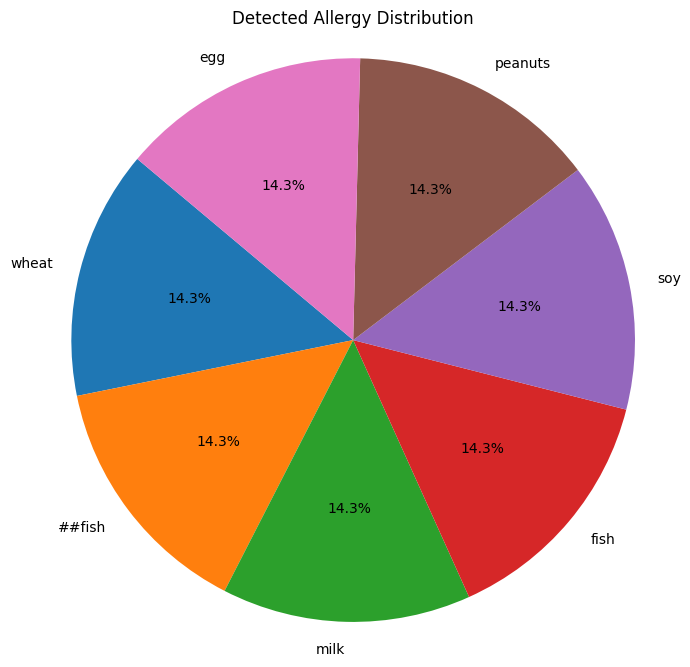

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from transformers import pipeline

# =============================================================================
# Data Loading
# =============================================================================
# Load the Food Allergens & Allergies dataset (from Kaggle)
df_allergens = pd.read_csv('/content/data2/FoodData.csv', low_memory=False)

# Load the World Food Facts dataset (from Kaggle)
df_food = pd.read_csv('/content/data/en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False)

# =============================================================================
# Initialize the FDA Nutrition NER Pipeline
# =============================================================================
model_name = "sgarbi/bert-fda-nutrition-ner"
# Use device=0 for GPU if available (adjust as needed)
ner_pipe = pipeline("token-classification", model=model_name, device=0)

# =============================================================================
# Utility Function: Normalize Text
# =============================================================================
def normalize_text(text):
    """
    Lowercases text and removes punctuation to improve matching.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# =============================================================================
# Function: Detect Allergens
# =============================================================================
def detect_allergic_ingredients(ingredients_text, known_allergens=None):
    """
    Uses the FDA Nutrition NER model to extract tokens from the ingredient list.
    It then filters these tokens by comparing against a list of common allergens.
    """
    if not ingredients_text:
        return []

    ner_results = ner_pipe(ingredients_text)
    # Start with a set of common allergens; you can expand this list or merge it with known allergens.
    common_allergens = {"peanuts", "gluten", "milk", "soy", "egg", "tree nut", "wheat", "fish", "shellfish"}
    if known_allergens:
        common_allergens.update(set(known_allergens))

    detected_allergens = []
    for result in ner_results:
        entity_word = normalize_text(result.get("word", ""))
        if any(allergen in entity_word for allergen in common_allergens):
            detected_allergens.append(result.get("word"))
    return list(set(detected_allergens))

# =============================================================================
# Function: Analyze Nutrients
# =============================================================================
def analyze_nutrients(ingredients_text):
    """
    Uses the NER pipeline to extract nutrient-related tokens from the ingredient text.
    It also checks for numeric patterns with common nutritional units.
    """
    if not ingredients_text:
        return []

    ner_results = ner_pipe(ingredients_text)
    nutrients = []
    for result in ner_results:
        entity_label = result.get("entity", "").lower()
        entity_word = result.get("word", "")
        # Check if the entity label suggests a nutrient
        if "nutrient" in entity_label:
            nutrients.append(entity_word)
        else:
            # If the token contains a number with a unit (g, mg, calories, etc.), consider it nutrient info.
            if re.search(r'\d+\s?(g|mg|calories|kj)', entity_word.lower()):
                nutrients.append(entity_word)
    return list(set(nutrients))

# =============================================================================
# Function: Suggest Alternative Products
# =============================================================================
def suggest_alternative_product(ingredients_text, detected_allergens, df_food, nutrition_threshold=10):
    """
    Searches the World Food Facts dataset for products that do NOT contain any of the detected allergens.
    Further nutritional similarity filtering can be added here.
    """
    allergens_lower = [normalize_text(a) for a in detected_allergens]

    def product_is_safe(text):
        text_norm = normalize_text(text)
        return not any(allergen in text_norm for allergen in allergens_lower)

    safe_products = df_food[df_food['ingredients_text'].apply(lambda x: product_is_safe(x))]

    if safe_products.empty:
        return "No alternative product found with a similar nutritional profile free of the detected allergens."

    # Return the top 3 safe products with their product name, nutrition score, and ingredients.
    suggestions = safe_products[['product_name', 'nutrition-score-fr_100g', 'ingredients_text']].head(3)
    return suggestions

# =============================================================================
# Function: Visualize Detected Allergen Distribution
# =============================================================================
def visualize_allergy_percentage(detected_allergens_list):
    """
    Plots a pie chart showing the distribution of detected allergens.
    """
    allergen_counts = {}
    for allergens in detected_allergens_list:
        for allergen in allergens:
            allergen_counts[allergen] = allergen_counts.get(allergen, 0) + 1

    if not allergen_counts:
        print("No allergens detected to visualize.")
        return

    labels = list(allergen_counts.keys())
    sizes = list(allergen_counts.values())

    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Detected Allergy Distribution")
    plt.show()

# =============================================================================
# Main: Process User-Entered Ingredient List and Output Results
# =============================================================================
def main():
    # Accept user input for the ingredient list.
    user_ingredients = input("Enter the ingredient list: ").strip()

    # # If the user does not enter anything, use a default sample.
    # if not user_ingredients:
    #     user_ingredients = (
    #         "This product contains wheat, milk, and peanuts. "
    #         "It also has sugar and a mix of natural flavors. "
    #         "Nutritionally, it offers 10g of protein and 5g of calcium."
    #     )

    # 1. Detect Allergens
    detected_allergens = detect_allergic_ingredients(user_ingredients)
    print("\nDetected Allergens:", detected_allergens)



    # 3. Suggest Alternative Products
    alternative_products = suggest_alternative_product(user_ingredients, detected_allergens, df_food)
    print("\nAlternative Product Suggestions:")
    print(alternative_products)

    # 4. (Optional) Visualize Allergen Distribution
    visualize_allergy_percentage([detected_allergens])

if __name__ == '__main__':
    main()



Food-Allergy dictionary sample:
almond: {'Nut Allergy'}
apple: {'Oral Allergy Syndrome'}
apricot: {'Stone Fruit Allergy'}
artichoke: {'Insulin Allergy'}
asparagus: {'Allium Allergy'}


Device set to use cuda:0


Enter the ingredient list: "peanuts", "gluten", "milk", "soy", "egg", "tree nut", "wheat", "fish", "shellfish"

Detected Allergens: ['Milk allergy / Lactose intolerance', 'Gluten Allergy', 'soy', 'peanuts', 'fish', 'egg', '##fish']

Detected Nutrients: []

Alternative Product Suggestions:
                     product_name  nutrition-score-fr_100g  \
0              Farine de blé noir                      NaN   
1  Banana Chips Sweetened (Whole)                     14.0   
3          Organic Salted Nut Mix                     12.0   

                                    ingredients_text  
0                                                     
1  Bananas, vegetable oil (coconut oil, corn oil ...  
3  Organic hazelnuts, organic cashews, organic wa...  


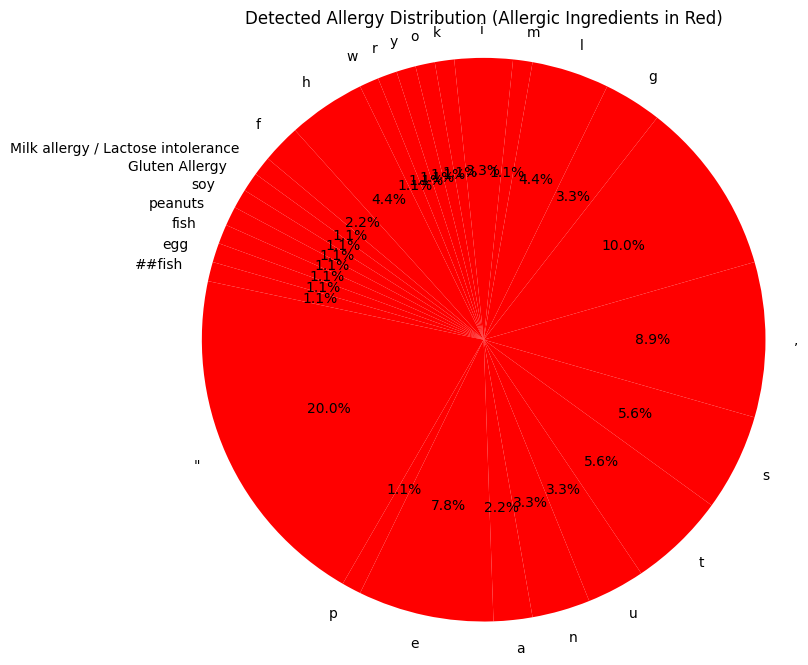

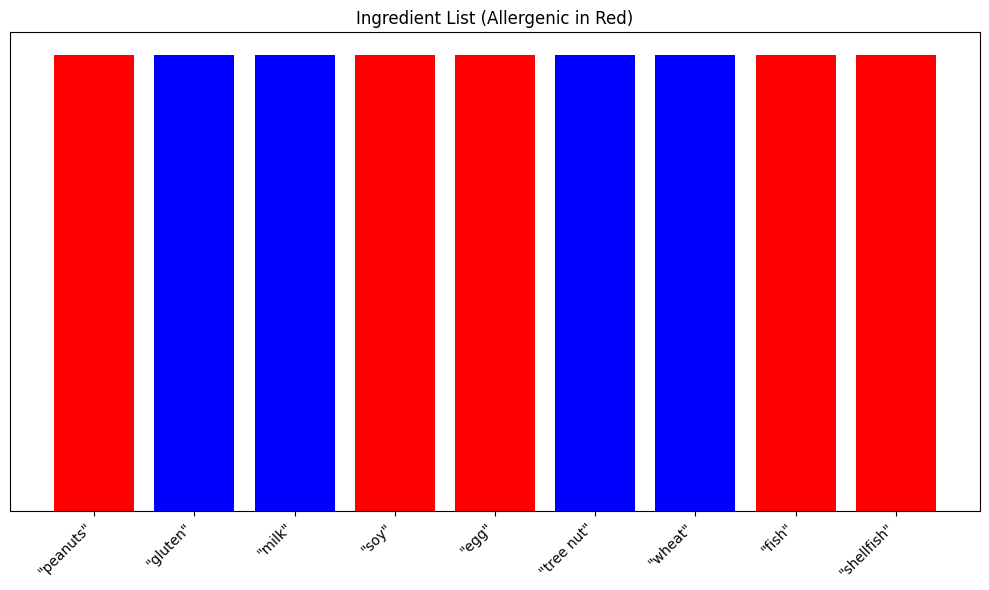

In [17]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from transformers import pipeline

# =============================================================================
# Data Loading and Setup
# =============================================================================
# Load the Food Allergens & Allergies dataset (from Kaggle)
df_allergens = pd.read_csv('/content/data2/FoodData.csv', low_memory=False)

# Build a dictionary mapping each food (lowercased and stripped) to its allergy label(s)
food_allergy_dict = {}
for idx, row in df_allergens.iterrows():
    food_key = str(row["Food"]).lower().strip()
    allergy_label = row["Allergy"]
    if food_key not in food_allergy_dict:
        food_allergy_dict[food_key] = set()
    food_allergy_dict[food_key].add(allergy_label)

print("\nFood-Allergy dictionary sample:")
for food, allergies in list(food_allergy_dict.items())[:5]:
    print(f"{food}: {allergies}")

# Load the World Food Facts dataset (from Kaggle)
df_food = pd.read_csv('/content/data/en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False)
# Replace missing ingredient texts with an empty string
df_food['ingredients_text'] = df_food['ingredients_text'].fillna("")

# =============================================================================
# Initialize the FDA Nutrition NER Pipeline
# =============================================================================
model_name = "sgarbi/bert-fda-nutrition-ner"
# Set device=0 to use GPU if available; adjust if necessary.
ner_pipe = pipeline("token-classification", model=model_name, device=0)

# =============================================================================
# Utility Function: Normalize Text
# =============================================================================
def normalize_text(text):
    """
    Lowercases text and removes punctuation to improve matching.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# =============================================================================
# Function: Detect Allergens
# =============================================================================
def detect_allergic_ingredients(ingredients_text, known_allergens=None):
    """
    Uses the FDA Nutrition NER model to extract tokens from the ingredient list.
    Checks each token against our food-allergy dictionary (from FoodData.csv)
    and against a set of common allergens.
    Returns a list of detected allergy labels.
    """
    if not ingredients_text:
        return []

    ner_results = ner_pipe(ingredients_text)
    detected_allergies = set()

    # Define a set of common allergens (expandable)
    common_allergens = {"peanuts", "gluten", "milk", "soy", "egg", "tree nut", "wheat", "fish", "shellfish"}
    if known_allergens:
        common_allergens.update(set(known_allergens))

    for result in ner_results:
        token = result.get("word", "")
        token_clean = normalize_text(token)
        # Check if token exists in our dictionary
        if token_clean in food_allergy_dict:
            detected_allergies.update(food_allergy_dict[token_clean])
        # Else, check if token (or part of it) is in the common allergens set
        elif any(allergen in token_clean for allergen in common_allergens):
            detected_allergies.add(token.strip())

    return list(detected_allergies)

# =============================================================================
# Function: Analyze Nutrients
# =============================================================================
def analyze_nutrients(ingredients_text):
    """
    Uses the NER pipeline to extract nutrient-related tokens from the ingredients text.
    Additionally, checks for numeric patterns with common nutritional units.
    """
    if not ingredients_text:
        return []

    ner_results = ner_pipe(ingredients_text)
    nutrients = []
    for result in ner_results:
        entity_label = result.get("entity", "").lower()
        entity_word = result.get("word", "")
        # If the model indicates a nutrient entity
        if "nutrient" in entity_label:
            nutrients.append(entity_word)
        else:
            # If the token contains numeric nutritional info (e.g., '10g', '5mg', 'calories')
            if re.search(r'\d+\s?(g|mg|calories|kj)', entity_word.lower()):
                nutrients.append(entity_word)
    return list(set(nutrients))

# =============================================================================
# Function: Suggest Alternative Products
# =============================================================================
def suggest_alternative_product(ingredients_text, detected_allergens, df_food, nutrition_threshold=10):
    """
    Searches the World Food Facts dataset for products that do NOT contain any of the detected allergens.
    (Further nutritional similarity filtering can be added if needed.)
    """
    allergens_lower = [normalize_text(a) for a in detected_allergens]

    def product_is_safe(text):
        text_norm = normalize_text(text)
        return not any(allergen in text_norm for allergen in allergens_lower)

    safe_products = df_food[df_food['ingredients_text'].apply(lambda x: product_is_safe(x))]

    if safe_products.empty:
        return "No alternative product found with a similar nutritional profile free of the detected allergens."

    # Return the top 3 safe products with selected columns.
    suggestions = safe_products[['product_name', 'nutrition-score-fr_100g', 'ingredients_text']].head(3)
    return suggestions

# =============================================================================
# Function: Visualize Allergen Distribution (Pie Chart)
# =============================================================================
def visualize_allergy_percentage(detected_allergens_list):
    """
    Plots a pie chart showing the distribution of detected allergens.
    All detected allergenic ingredients are shown in red.
    """
    allergen_counts = {}
    for allergens in detected_allergens_list:
        for allergen in allergens:
            allergen_counts[allergen] = allergen_counts.get(allergen, 0) + 1

    if not allergen_counts:
        print("No allergens detected to visualize.")
        return

    labels = list(allergen_counts.keys())
    sizes = list(allergen_counts.values())
    # All slices will be red since they represent allergenic ingredients.
    colors = ['red'] * len(labels)

    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title("Detected Allergy Distribution (Allergic Ingredients in Red)")
    plt.show()

# =============================================================================
# New Function: Visualize All Ingredients with Allergens Highlighted
# =============================================================================
def visualize_ingredients_allergy(ingredients_text, detected_allergens):
    """
    Splits the input ingredient list into individual ingredients (using commas)
    and visualizes them in a bar chart. Ingredients that are detected as allergenic
    are colored in red; others are shown in blue.
    """
    # Split ingredients by comma and strip extra spaces
    ingredients = [ing.strip() for ing in ingredients_text.split(',')]
    colors = []
    for ing in ingredients:
        ing_norm = normalize_text(ing)
        # If any detected allergen (normalized) appears in the ingredient, mark as allergenic (red)
        if any(normalize_text(allergen) in ing_norm for allergen in detected_allergens):
            colors.append('red')
        else:
            colors.append('blue')

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(ingredients)), [1]*len(ingredients), color=colors)
    plt.xticks(range(len(ingredients)), ingredients, rotation=45, ha='right')
    plt.title("Ingredient List (Allergenic in Red)")
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# =============================================================================
# Main: Process User-Entered Ingredient List and Output Results
# =============================================================================
def main():
    # Accept user input for the ingredient list.
    user_ingredients = input("Enter the ingredient list: ").strip()

    if not user_ingredients:
        print("No input provided. Exiting.")
        return

    # 1. Detect Allergens using our combined approach.
    detected_allergens = detect_allergic_ingredients(user_ingredients)
    print("\nDetected Allergens:", detected_allergens)

    # 2. Analyze Nutrients from the input (if available).
    detected_nutrients = analyze_nutrients(user_ingredients)
    print("\nDetected Nutrients:", detected_nutrients)

    # 3. Suggest Alternative Products based on allergen filtering.
    alternative_products = suggest_alternative_product(user_ingredients, detected_allergens, df_food)
    print("\nAlternative Product Suggestions:")
    print(alternative_products)

    # 4. Visualize Allergen Distribution (Pie Chart).
    visualize_allergy_percentage([detected_allergens,user_ingredients])

    # 5. Visualize full Ingredient List with allergenic ingredients highlighted in red.
    visualize_ingredients_allergy(user_ingredients, detected_allergens)

if __name__ == '__main__':
    main()
